## Data Loadout
Import all the libraries we will use for this project.  
Load in the data into a numpy array.  
Data: https://www.kaggle.com/datasnaek/league-of-legends  
Neural networks code reused from Homework 6

In [172]:
#Import files first
from sklearn.preprocessing import StandardScaler  # For scaling data
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 

In [173]:
# Importing data and separating features
lol_df = pd.read_csv('games.csv')
lol_df2 = lol_df[['gameDuration', 'winner','firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills']]
lol_X = lol_df2[['gameDuration', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills']]
lol_X = np.array(lol_X)
lol_Y = lol_df2[['winner']]
lol_Y = np.array(lol_Y)

print(lol_X)
print(lol_Y)

[[1949    2    1 ...    0    1    1]
 [1851    1    1 ...    0    0    0]
 [1493    2    1 ...    0    1    0]
 ...
 [2156    2    2 ...    0    2    0]
 [1475    2    2 ...    0    1    0]
 [1445    1    1 ...    0    1    0]]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]


In [174]:
# Scaling data
X_scale = StandardScaler()
lol_X_scale = X_scale.fit_transform(lol_X)

lol_X_scale[0,:] # Looking the new features after scaling

array([ 0.22780135,  1.01611295, -0.83013151, -0.45628079,  0.08734089,
       -0.77743196,  1.54200134,  1.39498948, -0.01387537,  2.78752472,
        1.33643434, -0.5796078 , -0.14231362, -0.78413297, -0.67541854,
       -0.33023792,  1.77900161])

In [175]:
# Splitting training/testing data 25/75
X_train, X_test, y_train, y_test = train_test_split(lol_X_scale, lol_Y, test_size = 0.75, train_size = 0.25)

In [176]:
# Setting up the output layer
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 2))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

# Convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

# Check
print(y_train[0:10])
print(y_v_train[0:10])

[[0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


## Neural Network Functions
Additional functions needed to implement neural networks.  
Functions taken from Homework 6.

In [177]:
# Activation function - Sigmoid
def f(z):
    # Sigmoid
    return 1 / (1 + np.exp(-z))

def f_deriv(z):
    # Sigmoid
    return f(z) * (1 - f(z))

In [178]:
# Creating and initializing W and b to random weights - optimal for sigmoid function
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [179]:
#Initializing▿𝑊 and▿𝑏 to zero arrays
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

In [180]:
# Feed forward
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

In [181]:
# Compute 𝛿
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [182]:
# Complete neural network function with back propagation
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25, lambda_var=0.001):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%100 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
            
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            # W[l] += -alpha * (1.0/N * tri_W[l])
            # regularization
            W[l] += -alpha * ((1.0/N * tri_W[l]) + (lambda_var*W[l]))
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
        
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

## Neural Network with Sigmoid Function, 1000 Iterations, Alpha = 0.25, Lambda = 0.001

Running the neural network using the sigmoid function as the activation function, 1000 iterations, alpha = 0.25, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000


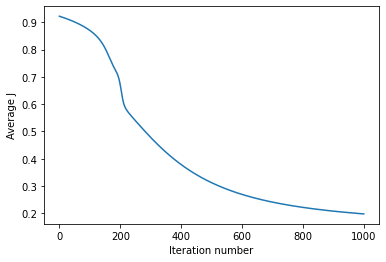

Prediction accuracy on training data is 95.17557489123679%
Prediction accuracy on testing data is 94.82365736185199%


In [183]:
nn_structure = [17, 15, 2]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 1000)

# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred) * 100))

y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred) * 100))

## Neural Network with Sigmoid Function, 2000 Iterations, Alpha = 0.25, Lambda = 0.001

Running the neural network using the sigmoid function as the activation function, 2000 iterations, alpha = 0.25, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

Starting gradient descent for 2000 iterations
Iteration 0 of 2000
Iteration 100 of 2000
Iteration 200 of 2000
Iteration 300 of 2000
Iteration 400 of 2000
Iteration 500 of 2000
Iteration 600 of 2000
Iteration 700 of 2000
Iteration 800 of 2000
Iteration 900 of 2000
Iteration 1000 of 2000
Iteration 1100 of 2000
Iteration 1200 of 2000
Iteration 1300 of 2000
Iteration 1400 of 2000
Iteration 1500 of 2000
Iteration 1600 of 2000
Iteration 1700 of 2000
Iteration 1800 of 2000
Iteration 1900 of 2000


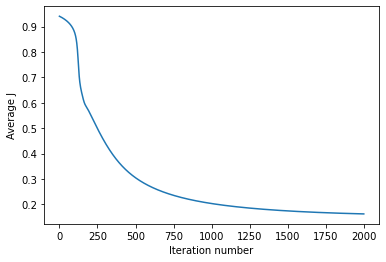

Prediction accuracy on training data is 95.85146053449347%
Prediction accuracy on testing data is 95.5176342638148%


In [184]:
nn_structure = [17, 15, 2]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 2000)

# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred) * 100))

y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred) * 100))

## Neural Network with Sigmoid Function, 3000 Iterations, Alpha = 0.25, Lambda = 0.001

Running the neural network using the sigmoid function as the activation function, 3000 iterations, alpha = 0.25, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 100 of 3000
Iteration 200 of 3000
Iteration 300 of 3000
Iteration 400 of 3000
Iteration 500 of 3000
Iteration 600 of 3000
Iteration 700 of 3000
Iteration 800 of 3000
Iteration 900 of 3000
Iteration 1000 of 3000
Iteration 1100 of 3000
Iteration 1200 of 3000
Iteration 1300 of 3000
Iteration 1400 of 3000
Iteration 1500 of 3000
Iteration 1600 of 3000
Iteration 1700 of 3000
Iteration 1800 of 3000
Iteration 1900 of 3000
Iteration 2000 of 3000
Iteration 2100 of 3000
Iteration 2200 of 3000
Iteration 2300 of 3000
Iteration 2400 of 3000
Iteration 2500 of 3000
Iteration 2600 of 3000
Iteration 2700 of 3000
Iteration 2800 of 3000
Iteration 2900 of 3000


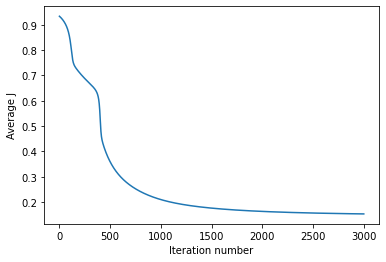

Prediction accuracy on training data is 96.10783095090119%
Prediction accuracy on testing data is 95.9138225697861%


In [186]:
nn_structure = [17, 15, 2]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)

# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred) * 100))

y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred) * 100))

## Neural Network with Sigmoid Function, 1000 Iterations, Alpha = 0.1, Lambda = 0.001
Running the neural network using the sigmoid function as the activation function, 1000 iterations, alpha = 0.1, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000


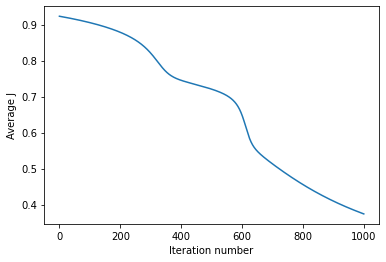

Prediction accuracy on training data is 89.88502175264139%
Prediction accuracy on testing data is 89.69133564658968%


In [187]:
nn_structure = [17, 15, 2]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 1000, 0.1)

# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred) * 100))

y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred) * 100))

## Neural Network with Sigmoid Function, 3000 Iterations, Alpha = 0.1, Lambda = 0.001
Running the neural network using the sigmoid function as the activation function, 3000 iterations, alpha = 0.1, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 100 of 3000
Iteration 200 of 3000
Iteration 300 of 3000
Iteration 400 of 3000
Iteration 500 of 3000
Iteration 600 of 3000
Iteration 700 of 3000
Iteration 800 of 3000
Iteration 900 of 3000
Iteration 1000 of 3000
Iteration 1100 of 3000
Iteration 1200 of 3000
Iteration 1300 of 3000
Iteration 1400 of 3000
Iteration 1500 of 3000
Iteration 1600 of 3000
Iteration 1700 of 3000
Iteration 1800 of 3000
Iteration 1900 of 3000
Iteration 2000 of 3000
Iteration 2100 of 3000
Iteration 2200 of 3000
Iteration 2300 of 3000
Iteration 2400 of 3000
Iteration 2500 of 3000
Iteration 2600 of 3000
Iteration 2700 of 3000
Iteration 2800 of 3000
Iteration 2900 of 3000


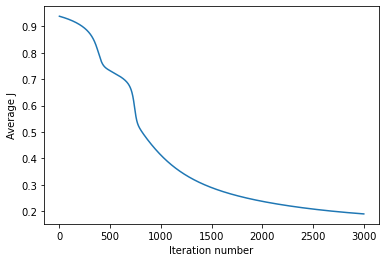

Prediction accuracy on training data is 94.9580484773151%
Prediction accuracy on testing data is 94.52068983375628%


In [188]:
nn_structure = [17, 15, 2]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, 0.1)

# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred) * 100))

y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred) * 100))

## Neural Network with ReLU Function, 1000 Iterations, Alpha = 0.01, Lambda = 0.001

Running the neural network using the ReLU function as the activation function, 1000 iterations, alpha = 0.01, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000


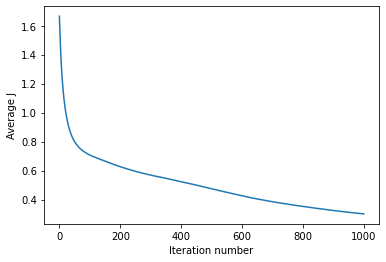

Prediction accuracy on training data is 71.6438781852082%
Prediction accuracy on testing data is 71.65311512766067%


In [189]:
# Redefining f(z) and f_deriv(z) to set activation function to ReLU
def f(z):
    # ReLU
    return np.maximum(np.zeros_like(z), z)

def f_deriv(z):
    # ReLU
    z_ret = np.zeros_like(z)
    for i in range(len(z)):
        if z[i] < 0:
            z_ret[i] = 0
        elif z[i] >= 0:
            z_ret[i] = 1
    return z_ret

# Redefining for ReLU initialization weights
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.normal(0, np.sqrt(2) * np.sqrt(2/ (nn_structure[l] + nn_structure[l-1])), (nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.normal(0, np.sqrt(2) * np.sqrt(2/ (nn_structure[l])), (nn_structure[l],))
    return W, b

# Running neural network, plotting cost, and displaying accuracy

nn_structure_r = [17, 15, 2]
    
# train the NN
W_r, b_r, avg_cost_func_r = train_nn(nn_structure_r, X_train, y_train, 1000, 0.01)

# plot the avg_cost_func
plt.plot(avg_cost_func_r)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred_r = predict_y(W_r, b_r, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred_r) * 100))

y_pred_r = predict_y(W_r, b_r, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred_r) * 100))

## Neural Network with ReLU Function, 3000 Iterations, Alpha = 0.01, Lambda = 0.001

Running the neural network using the ReLU function as the activation function, 3000 iterations, alpha = 0.01, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 100 of 3000
Iteration 200 of 3000
Iteration 300 of 3000
Iteration 400 of 3000
Iteration 500 of 3000
Iteration 600 of 3000
Iteration 700 of 3000
Iteration 800 of 3000
Iteration 900 of 3000
Iteration 1000 of 3000
Iteration 1100 of 3000
Iteration 1200 of 3000
Iteration 1300 of 3000
Iteration 1400 of 3000
Iteration 1500 of 3000
Iteration 1600 of 3000
Iteration 1700 of 3000
Iteration 1800 of 3000
Iteration 1900 of 3000
Iteration 2000 of 3000
Iteration 2100 of 3000
Iteration 2200 of 3000
Iteration 2300 of 3000
Iteration 2400 of 3000
Iteration 2500 of 3000
Iteration 2600 of 3000
Iteration 2700 of 3000
Iteration 2800 of 3000
Iteration 2900 of 3000


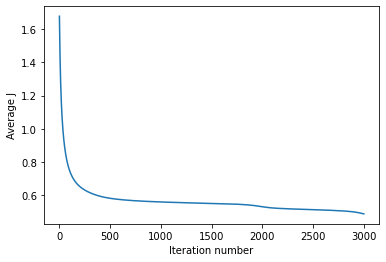

Prediction accuracy on training data is 54.746737103791176%
Prediction accuracy on testing data is 54.311460976746595%


In [190]:
# train the NN with 0.01 alpha
W_r, b_r, avg_cost_func_r = train_nn(nn_structure_r, X_train, y_train, 3000, 0.01)

# plot the avg_cost_func
plt.plot(avg_cost_func_r)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred_r = predict_y(W_r, b_r, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred_r) * 100))

y_pred_r = predict_y(W_r, b_r, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred_r) * 100))

## Neural Network with ReLU Function, 1000 Iterations, Alpha = 0.25, Lambda = 0.001

Running the neural network using the ReLU function as the activation function, 1000 iterations, alpha = 0.25, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000


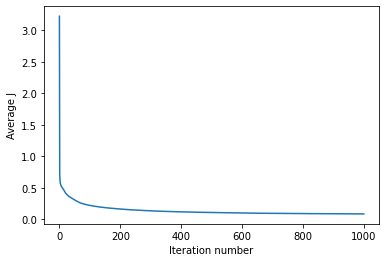

Prediction accuracy on training data is 71.1311373523928%
Prediction accuracy on testing data is 70.73644414521726%


In [191]:
# train the NN with 0.25 alpha
W_r, b_r, avg_cost_func_r = train_nn(nn_structure_r, X_train, y_train, 1000)

# plot the avg_cost_func
plt.plot(avg_cost_func_r)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred_r = predict_y(W_r, b_r, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred_r) * 100))

y_pred_r = predict_y(W_r, b_r, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred_r) * 100))

## Neural Network with ReLU Function, 3000 Iterations, Alpha = 0.25, Lambda = 0.001

Running the neural network using the ReLU function as the activation function, 3000 iterations, alpha = 0.25, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 100 of 3000
Iteration 200 of 3000
Iteration 300 of 3000
Iteration 400 of 3000
Iteration 500 of 3000
Iteration 600 of 3000
Iteration 700 of 3000
Iteration 800 of 3000
Iteration 900 of 3000
Iteration 1000 of 3000
Iteration 1100 of 3000
Iteration 1200 of 3000
Iteration 1300 of 3000
Iteration 1400 of 3000
Iteration 1500 of 3000
Iteration 1600 of 3000
Iteration 1700 of 3000
Iteration 1800 of 3000
Iteration 1900 of 3000
Iteration 2000 of 3000
Iteration 2100 of 3000
Iteration 2200 of 3000
Iteration 2300 of 3000
Iteration 2400 of 3000
Iteration 2500 of 3000
Iteration 2600 of 3000
Iteration 2700 of 3000
Iteration 2800 of 3000
Iteration 2900 of 3000


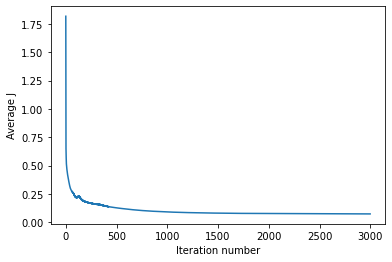

Prediction accuracy on training data is 67.5497203231821%
Prediction accuracy on testing data is 67.47112745351909%


In [192]:
# train the NN with 0.25 alpha and 3000 iters
W_r, b_r, avg_cost_func_r = train_nn(nn_structure_r, X_train, y_train, 3000)

# plot the avg_cost_func
plt.plot(avg_cost_func_r)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred_r = predict_y(W_r, b_r, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred_r) * 100))

y_pred_r = predict_y(W_r, b_r, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred_r) * 100))

## Neural Network with Leaky ReLU Function, 1000 Iterations, Alpha = 0.25, Lambda = 0.001

Running the neural network using the Leaky ReLU function as the activation function, 1000 iterations, alpha = 0.25, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

In [ ]:
# Redefining f(z) and f_deriv(z) to set activation function to Leaky ReLU
def f(z):
    # Leaky ReLU
    return np.maximum(0.01 * z, z)

def f_deriv(z):
    # Leaky ReLU
    z_ret = np.zeros_like(z)
    for i in range(len(z)):
        if z[i] < 0:
            z_ret[i] = 0.01
        elif z[i] >= 0:
            z_ret[i] = 1
    return z_ret

# Running neural network, plotting cost, and displaying accuracy

nn_structure_lr = [17, 15, 2]
    
# train the NN
W_lr, b_lr, avg_cost_func_lr = train_nn(nn_structure_lr, X_train, y_train, 1000)

# plot the avg_cost_func
plt.plot(avg_cost_func_lr)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred_lr = predict_y(W_lr, b_lr, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred_lr) * 100))

y_pred_lr = predict_y(W_lr, b_lr, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred_lr) * 100))

Starting gradient descent for 1000 iterations
Iteration 0 of 1000


KeyboardInterrupt: 

## Neural Network with Leaky ReLU Function, 2000 Iterations, Alpha = 0.25, Lambda = 0.001

Running the neural network using the Leaky ReLU function as the activation function, 2000 iterations, alpha = 0.25, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

In [ ]:
# Running neural network, plotting cost, and displaying accuracy

nn_structure_lr = [17, 15, 2]
    
# train the NN
W_lr, b_lr, avg_cost_func_lr = train_nn(nn_structure_lr, X_train, y_train, 2000)

# plot the avg_cost_func
plt.plot(avg_cost_func_lr)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred_lr = predict_y(W_lr, b_lr, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred_lr) * 100))

y_pred_lr = predict_y(W_lr, b_lr, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred_lr) * 100))

## Neural Network with Leaky ReLU Function, 1000 Iterations, Alpha = 0.01, Lambda = 0.001

Running the neural network using the Leaky ReLU function as the activation function, 1000 iterations, alpha = 0.01, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

In [ ]:
# Running neural network, plotting cost, and displaying accuracy

nn_structure_lr = [17, 15, 2]
    
# train the NN
W_lr, b_lr, avg_cost_func_lr = train_nn(nn_structure_lr, X_train, y_train, 1000, 0.01)

# plot the avg_cost_func
plt.plot(avg_cost_func_lr)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred_lr = predict_y(W_lr, b_lr, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred_lr) * 100))

y_pred_lr = predict_y(W_lr, b_lr, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred_lr) * 100))

## Neural Network with Leaky ReLU Function, 3000 Iterations, Alpha = 0.01, Lambda = 0.001

Running the neural network using the Leaky ReLU function as the activation function, 3000 iterations, alpha = 0.01, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

In [ ]:
# Running neural network, plotting cost, and displaying accuracy

nn_structure_lr = [17, 15, 2]
    
# train the NN
W_lr, b_lr, avg_cost_func_lr = train_nn(nn_structure_lr, X_train, y_train, 3000, 0.01)

# plot the avg_cost_func
plt.plot(avg_cost_func_lr)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred_lr = predict_y(W_lr, b_lr, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred_lr) * 100))

y_pred_lr = predict_y(W_lr, b_lr, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred_lr) * 100))

## Neural Network with Leaky ReLU Function, 6000 Iterations, Alpha = 0.01, Lambda = 0.001

Running the neural network using the Leaky ReLU function as the activation function, 6000 iterations, alpha = 0.01, and lambda = 0.001.  
Plotting the average cost per iteration and displaying the final train/test accuracy.

In [ ]:
# Running neural network, plotting cost, and displaying accuracy

nn_structure_lr = [17, 15, 2]
    
# train the NN
W_lr, b_lr, avg_cost_func_lr = train_nn(nn_structure_lr, X_train, y_train, 6000, 0.01)

# plot the avg_cost_func
plt.plot(avg_cost_func_lr)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

# get the prediction accuracy and print
y_pred_lr = predict_y(W_lr, b_lr, X_train, 3)
print('Prediction accuracy on training data is {}%'.format(accuracy_score(y_train, y_pred_lr) * 100))

y_pred_lr = predict_y(W_lr, b_lr, X_test, 3)
print('Prediction accuracy on testing data is {}%'.format(accuracy_score(y_test, y_pred_lr) * 100))